In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import os
import re
import pickle

from IPython.display import display, HTML
from tqdm.auto import tqdm

sns.set(style="darkgrid")  # seaborn 스타일 설정

%matplotlib inline
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import os
import re
import pandas as pd
motion = []
def get_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else None

path = '/Users/ohheungchan/workspace/AI_Study/Paperwork/motion-and-heart-rate-from-a-wrist-worn-wearable-and-labeled-sleep-from-polysomnography-1.0.0/motion'
file_list = os.listdir(path)
file_list_txt = sorted([file for file in file_list if get_number(file) is not None], key=get_number)

for I in file_list_txt:
    df = pd.read_csv(os.path.join(path, I), sep=' ', header=None, names=['time', 'x', 'y', 'z'])
    motion.append(df)
df

,time,x,y,z
0,-563.032824,0.052033,-0.612061,-0.781113
1,-563.014347,0.055008,-0.605698,-0.785004
2,-562.995023,0.053024,-0.608139,-0.783569
3,-562.984044,0.048141,-0.610611,-0.788055
4,-562.964345,0.049652,-0.608643,-0.790497
...,...,...,...,...
1709995,29566.218889,0.332993,0.339142,0.885254
1709996,29566.220181,0.335480,0.337677,0.884323
1709997,29566.221054,0.333023,0.337677,0.883301
1709998,29566.221875,0.332504,0.335236,0.885742


In [5]:
import os
import re
import pandas as pd

def get_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else None

heart_rate = []
path = '/Users/ohheungchan/workspace/AI_Study/Paperwork/motion-and-heart-rate-from-a-wrist-worn-wearable-and-labeled-sleep-from-polysomnography-1.0.0/heart_rate'
file_list = os.listdir(path)
file_list_txt = sorted([file for file in file_list if get_number(file) is not None], key=get_number)

for i in file_list_txt:
    df = pd.read_csv(os.path.join(path, i), header=None, names=['time', 'bpm'])
    heart_rate.append(df)

df

,time,bpm
0,-54171.73757,77
1,-53789.74320,81
2,-53332.83677,74
3,-53077.83538,67
4,-52865.83576,76
...,...,...
15988,29050.53076,89
15989,29120.40579,140
15990,29122.40576,141
15991,29205.40576,197


In [7]:
label = []
path = '/Users/ohheungchan/workspace/AI_Study/Paperwork/motion-and-heart-rate-from-a-wrist-worn-wearable-and-labeled-sleep-from-polysomnography-1.0.0/labels'
file_list = os.listdir(path)
file_list_txt = sorted([file for file in file_list if get_number(file) is not None], key=get_number)

for i in file_list_txt:
    df = pd.read_csv(os.path.join(path, i), sep=' ', header=None, names=['time', 'label'])
    label.append(df)
df

,time,label
0,0,0
1,30,0
2,60,0
3,90,0
4,120,0
...,...,...
715,21450,0
716,21480,0
717,21510,0
718,21540,0


In [8]:
from scipy.signal import butter, filtfilt

# 샘플링 주파수와 절반 주파수 설정
fs = 10 
fn = fs/2

band_motion = []
col_names = ['x', 'y', 'z']

for i in range(len(motion)):
    sub = motion[i].drop('time' ,axis=1)

    # 밴드 필터링된 데이터 배열 초기화
    band_data = np.zeros(sub.shape)

    # 각 채널에 대해 필터링 수행
    for ch in range(3):
        x = sub.iloc[:, ch]
        b, a = butter(3, 0.5 / fn, btype='high')
        band_data[:, ch] = filtfilt(b, a, x) 
    
    # 밴드 필터링된 데이터를 데이터프레임 형식으로 변환
    df = pd.DataFrame(band_data, columns=col_names)
    
    # 시간 컬럼 추가
    res = pd.concat([motion[i]['time'], df], axis=1)
    band_motion.append(res)

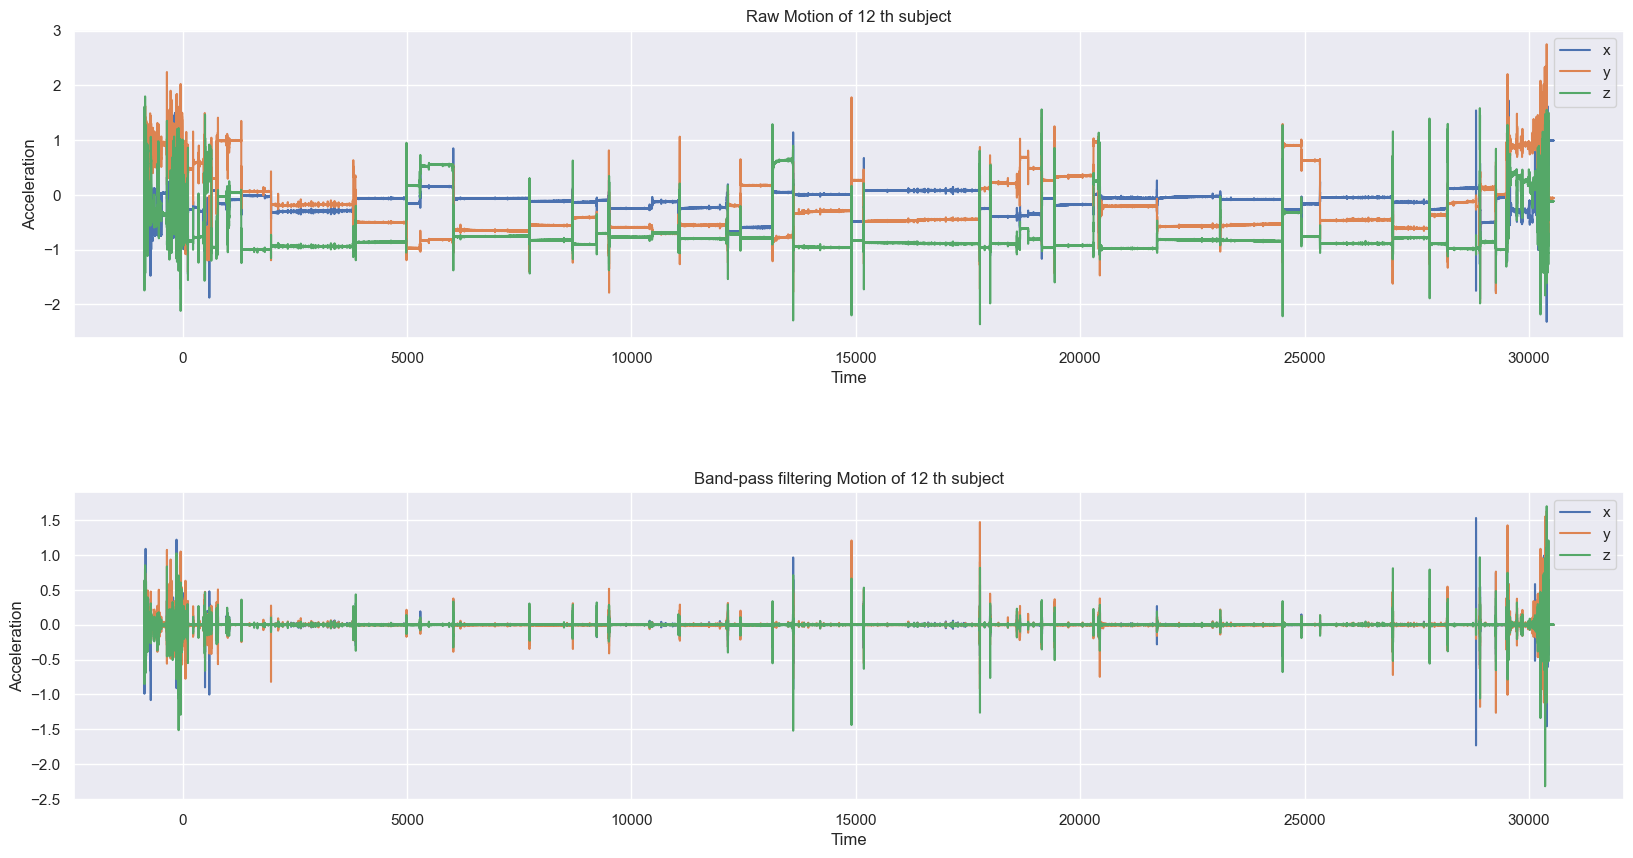

In [9]:

# band-pass filtering 전후 그래프 확인

f, ax = plt.subplots(2, 1, figsize=(20,10))

motion[12].plot(x='time', y=['x', 'y', 'z'], ax=ax[0])

# 그래프 제목 설정
ax[0].set_title('Raw Motion of 12 th subject')

# 축 레이블 설정
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Acceleration')

band_motion[12].plot(x='time', y=['x', 'y', 'z'], ax=ax[1])

# 그래프 제목 설정
ax[1].set_title('Band-pass filtering Motion of 12 th subject')

# 축 레이블 설정
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Acceleration')


# subplot 간의 수직 간격 조절
plt.subplots_adjust(hspace=0.5)

plt.show()

In [10]:

# motion time을 int형으로 바꿈
for i in range(len(band_motion)):
    band_motion[i]['time'] = band_motion[i]['time'].astype(int)
    

# hear_rate time int형으로 바꿈
for i in range(len(heart_rate)):
    heart_rate[i]['time'] = heart_rate[i]['time'].astype(int)

In [11]:

# 잘 변환되었는지 확인
band_motion[0].head()

,time,x,y,z
0,-124489,-0.000193,0.000295,0.000231
1,-124489,0.000224,-0.003133,-0.002445
2,-124489,0.001090,0.005249,-0.007707
3,-124489,-0.001526,0.004942,-0.005789
4,-124489,-0.005133,-0.001598,0.001742


In [12]:

# 잘 변환되었는지 확인
heart_rate[0].head()

,time,bpm
0,-556410,57
1,-556408,56
2,-556403,56
3,-556399,57
4,-556389,59


In [13]:
for i in range(len(band_motion)):
    band_motion[i] = band_motion[i][(band_motion[i]['time'] >= 0) & (band_motion[i]['time'] <= label[i]['time'].max())]
    heart_rate[i] = heart_rate[i][(heart_rate[i]['time'] >= 0) & (heart_rate[i]['time'] <= label[i]['time'].max())]

In [14]:
print('sub / len heart_rate time / len motion time / max motion time / max label time')

for i in range(len(band_motion)):
    print(i, len(heart_rate[i]['time'].unique()), len(band_motion[i]['time'].unique()), band_motion[i]['time'].max(), label[i]['time'].max())

sub / len heart_rate time / len motion time / max motion time / max label time
0 3302 16981 16980 16980
1 2843 13586 14220 14220
2 5652 29302 29400 29400
3 5467 28362 28440 28440
4 4964 23773 28394 28530
5 5574 27692 29010 29010
6 5549 26358 28920 28920
7 5717 29671 29670 29670
8 5702 29611 29610 29610
9 5334 25318 29460 29460
10 5537 29041 29040 29040
11 2496 12481 12480 12480
12 5673 29281 29280 29280
13 3054 14795 14940 15270
14 5575 29071 29070 29070
15 5637 29371 29370 29370
16 2784 13907 13920 13920
17 5609 29302 29310 29310
18 4382 22662 22740 22740
19 5584 28831 28830 28830
20 5691 29431 29430 29430
21 837 3901 4024 28770
22 5581 28506 28920 28920
23 5652 29521 29520 29520
24 5625 29131 29130 29130
25 5526 26864 28950 28950
26 5618 29101 29100 29100
27 5537 28921 28920 28920
28 5619 29202 29220 29220
29 5421 28321 28320 28320
30 4007 21571 21570 21570


In [15]:
# 수면 시간이 7.5시간이 안 되는 피험자는 제외 (label[i]['time'].max() < 27000이면 제외 )

less_sleep_idx = set()

for i in range(len(band_motion)):
    if label[i]['time'].max() < 27000:
        less_sleep_idx.add(i)

less_sleep_idx

{0, 1, 11, 13, 16, 18, 30}

In [16]:
# 중간에 -1이 있는 피험자 제외

label_err = {6, 17, 19, 22, 24, 25} 

err_sub_idx = less_sleep_idx | label_err

len(err_sub_idx), err_sub_idx

(13, {0, 1, 6, 11, 13, 16, 17, 18, 19, 22, 24, 25, 30})

In [17]:

select_sub_idx = list(set(range(31)) - err_sub_idx)

select_sub_idx

[2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 20, 21, 23, 26, 27, 28, 29]

In [18]:

# 선택된 피험자만 넘파이 배열로 변환

heart_rate = np.array(heart_rate, dtype=object)[select_sub_idx]
label = np.array(label, dtype=object)[select_sub_idx]
band_motion = np.array(band_motion, dtype=object)[select_sub_idx]

In [19]:
for i in range(len(label)):
    print(label[i]['label'].unique())

[0 5 1 2 3]
[-1  0  1  2  3  5]
[0 1 2 3 5]
[-1  0  1  2  3  5]
[-1  0  1  2  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[0 1 2 3 5]
[-1  0  2  1  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[0 1 2 3 4 5]


In [20]:

# 깊은 수면이 없고 라벨이 4가 있는 피험자 제외

heart_rate = np.delete(heart_rate, [4, -1], axis=0)
label = np.delete(label, [4, -1], axis=0)
band_motion = np.delete(band_motion, [4, -1], axis=0)

In [21]:

# 최종적으로 16명의 피험자의 수면을 분류할 예정
len(heart_rate), len(label), len(band_motion)

(16, 16, 16)

In [22]:

interpol_heart_rate = []

for i in range(len(heart_rate)):
    df = heart_rate[i]

    # 보간할 시간 범위 생성
    interpol_time_range = np.arange(df['time'].min(), df['time'].max() + 1)

    # 누락된 시간에 대한 bpm 값 NaN으로 설정한 새로운 데이터프레임 생성
    interpol_df = pd.DataFrame({'time': interpol_time_range})
    interpol_df['bpm'] = np.nan

    # 원본 데이터와 보간된 데이터프레임을 합치기
    new_df = pd.concat([df, interpol_df], ignore_index=True)

    #중복된 time 제거 (interpol_df의 NAN을 제거)
    new_df = new_df.drop_duplicates(subset='time', keep='first')

    # 시간을 기준으로 정렬
    new_df = new_df.sort_values('time')

    # NaN 값 채우기
    new_df['bpm'].interpolate(inplace=True)

    # 인덱스 초기화
    new_df = new_df.reset_index(drop=True)
    
    interpol_heart_rate.append(new_df)

In [23]:

# 보간이 잘되었는지 확인
interpol_heart_rate[0].head(20)


,time,bpm
0,1,65.000000
1,2,65.000000
2,3,65.000000
3,4,65.000000
4,5,65.000000
5,6,65.000000
6,7,65.222222
7,8,65.444444
8,9,65.666667
9,10,65.888889


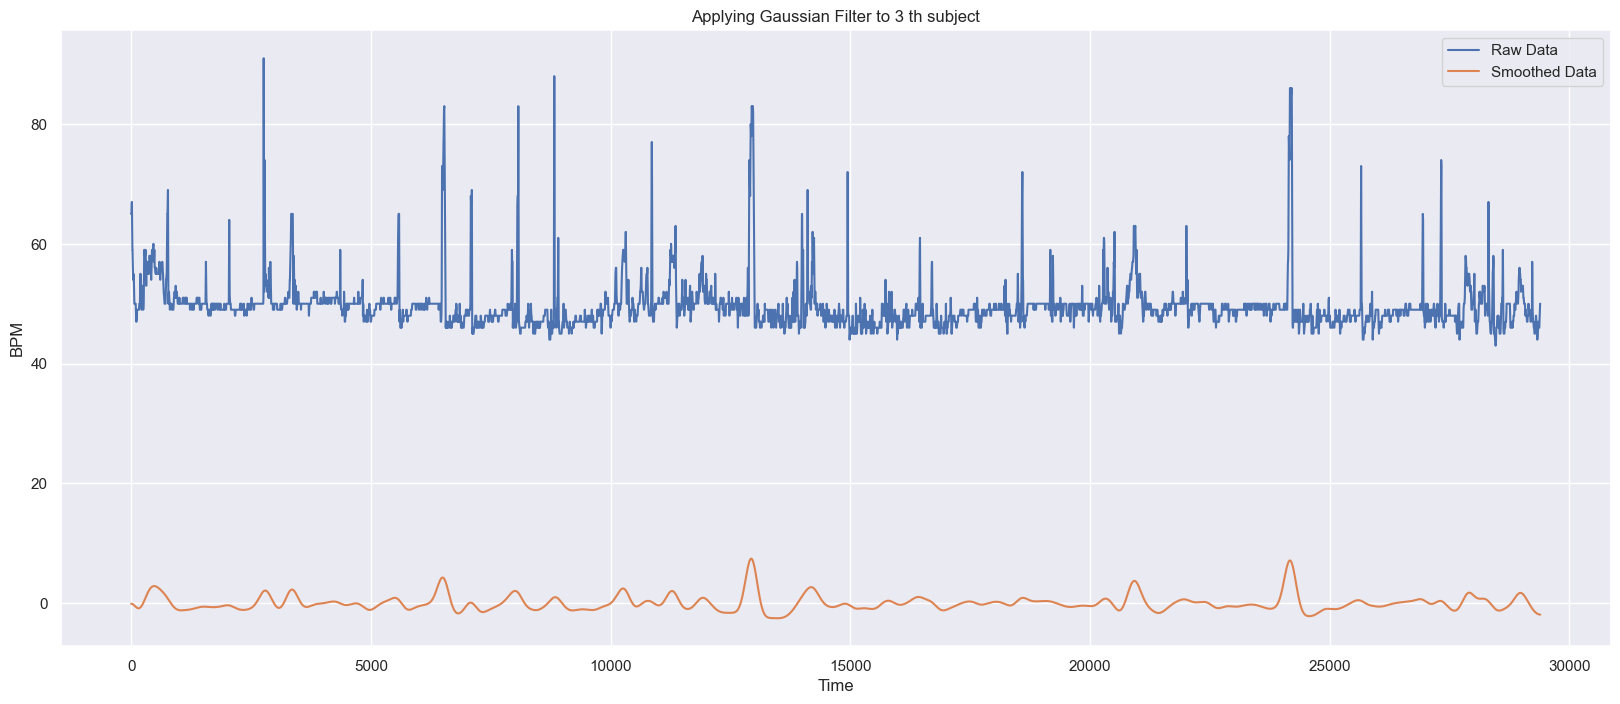

In [24]:
from scipy.ndimage import gaussian_filter


## 예시
data = interpol_heart_rate[0]['bpm']

# 차이 가우시안 필터 적용
sigma1 = 120  # 첫 번째 가우시안 필터의 표준편차
sigma2 = 600  # 두 번째 가우시안 필터의 표준편차

gaussian_smoothed = gaussian_filter(data, sigma1) - gaussian_filter(data, sigma2)

# 결과 시각화
plt.figure(figsize=(20, 8))
plt.plot(data, label='Raw Data')
plt.plot(gaussian_smoothed, label='Smoothed Data')
plt.xlabel('Time')
plt.ylabel('BPM')
plt.title('Applying Gaussian Filter to 3 th subject')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
filter_heart_rate = []

# 차이 가우시안 필터 적용
sigma1 = 120  # 첫 번째 가우시안 필터의 표준편차
sigma2 = 600  # 두 번째 가우시안 필터의 표준편차

for i in range(len(heart_rate)):
    data = interpol_heart_rate[i]['bpm']
    gaussian_smoothed = gaussian_filter(data, sigma1) - gaussian_filter(data, sigma2)
    
    df = pd.DataFrame({'time': interpol_heart_rate[i]['time'], 'bpm': gaussian_smoothed})
    filter_heart_rate.append(df)

In [26]:
# 정규화 함수 정의
def normalize_data(df):
    avg = df['bpm'].mean()
    diff = np.abs(df['bpm'] - avg)
    percentile_90 = np.percentile(diff, 90)
    normalized_value = df['bpm'] / percentile_90
    return normalized_value

for i in range(len(filter_heart_rate)):
    filter_heart_rate[i]['bpm'] = normalize_data(filter_heart_rate[i])    

# 잘 되었는지 확인
filter_heart_rate[0]

,time,bpm
0,1,-0.060843
1,2,-0.060921
2,3,-0.061078
3,4,-0.061312
4,5,-0.061626
...,...,...
29393,29394,-1.007394
29394,29395,-1.007552
29395,29396,-1.007670
29396,29397,-1.007749


In [27]:

for i in range(len(label)):
    label[i]['label'].replace(-1, 0, inplace=True)


In [28]:
def katz_fd(x, axis=-1):
    """Katz Fractal Dimension.

    Parameters
    ----------
    x : list or np.array
        1D or N-D data.
    axis : int
        The axis along which the FD is calculated. Default is -1 (last).

    Returns
    -------
    kfd : float
        Katz fractal dimension.

    Notes
    -----
    Katz’s method calculates the fractal dimension of a sample as follows:
    the sum and average of the Euclidean distances between the successive
    points of the sample (:math:`L` and :math:`a` , resp.) are calculated as
    well as the maximum distance between the first point and any other point
    of the sample (:math:`d`). The fractal dimension of the sample (:math:`D`)
    then becomes:

    .. math::
        D = \\frac{\\log_{10}(L/a)}{\\log_{10}(d/a)} =
        \\frac{\\log_{10}(n)}{\\log_{10}(d/L)+\\log_{10}(n)}

    where :math:`n` is :math:`L` divided by :math:`a`.

    Original code from the `mne-features <https://mne.tools/mne-features/>`_
    package by Jean-Baptiste Schiratti and Alexandre Gramfort.

    References
    ----------
    * https://ieeexplore.ieee.org/abstract/document/904882

    * https://hal.inria.fr/inria-00442374/

    * https://www.hindawi.com/journals/ddns/2011/724697/

    Examples
    --------
    >>> import numpy as np
    >>> import entropy as ent
    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    6.4713

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    4.5720

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    7.6540

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ent.katz_fd(rng.random(1000)):.4f}")
    8.1531

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ent.katz_fd(x):.4f}")
    2.4871

    Linearly-increasing time-series (should be 1)

    >>> x = np.arange(1000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    1.0000
    """

    x = np.array(x)
  
    dists = np.abs(np.diff(x, axis=axis))
    ll = dists.sum(axis=axis) 
    ln = np.log10(ll / dists.mean(axis=axis))
    aux_d = x - np.take(x, indices=[0], axis=axis)
    d = np.max(np.abs(aux_d), axis=axis)
    kfd = np.squeeze(ln / (ln + np.log10(d / ll)))
    
    if not kfd.ndim:
        kfd = kfd.item()
    
    return kfd


In [29]:
def rms(data):
    squared_data = np.square(data)  # 각 데이터의 제곱값 계산
    mean_squared = np.mean(squared_data)  # 제곱값의 평균 계산
    root_mean_square = np.sqrt(mean_squared)  # 평균의 제곱근 계산
    return root_mean_square

In [30]:

def get_features_mt(df, max_time, func_list):

    # 시간 범위 인덱스
    time_idx = 1

    # 계산된 피쳐 리스트
    feat = []

    while 30 * (time_idx - 1) <= max_time:

        ## time slicing ##
        # label은 30초 단위로 기록되어 있으므로 0 ~ 29, 30 ~ 59, .. 의 기록의 통계량을 feature로 만듦
        # 이때, x, y, z 각각 따로 줘야됨
        tmp_df = df[( df['time'] >= 30 * (time_idx - 1) ) & (df['time'] <= 30 * time_idx - 1)]
        time_idx += 1

        ## 피쳐 적용 ##
        tmp_feat = []
        for func in func_list:
            for i in ['x', 'y', 'z']:
                if tmp_df[i].size == 0: # 해당 구간의 데이터가 없다면
                    tmp_feat.append(np.NAN) # NaN으로 채우기
                else:
                    res = func(tmp_df[i])
                    tmp_feat.append(res)

        feat.append(tmp_feat)

    return feat

In [31]:

# 최종적으로 피험자별 수면 데이터를 담을 리스트
sleep_df = [] 

# feature 이름으로 data frame columns 설정
func_name = ['mean', 'std', 'var', 'max', 'rms', 'katz_fd']
mt_col = [] # motion columns 리스트

# mt 접두사와 해당하는 축으로(x, y, z) 접미사 붙이기
for func in func_name:
    for ax in ['x', 'y', 'z']:
        col_name = 'mt_' + func + f'_{ax}'
        mt_col.append(col_name)
    
# columns 이름 출력
print(mt_col)
        
# 각 피험자별로 iteration
for i in tqdm(range(len(band_motion))):
    mt_df, target = band_motion[i], label[i]
    
    # feature selection 작업
    mt_arr = np.array( get_features_mt(mt_df, target['time'].max(), [np.mean, np.std, np.var, np.max, rms, katz_fd]) )

    # 결측치가 있는 행은 이전 행의 데이터로 대체
    for j in range(len(mt_arr)):
        if np.isnan(mt_arr[j]).any():
            mt_arr[j] = mt_arr[j-1].copy()
    
    # feature selection이 잘 되었는지 확인 (motion의 row와 target의 row 개수가 같아야 됨)
    print(mt_arr.shape, target.shape)
    
    # array를 data frame으로 변환 후 sleep_df에 추가
    mt_df = pd.DataFrame(mt_arr, columns=mt_col)
    df = pd.concat([target['label'], mt_df], axis=1)
    
    sleep_df.append(df)

['mt_mean_x', 'mt_mean_y', 'mt_mean_z', 'mt_std_x', 'mt_std_y', 'mt_std_z', 'mt_var_x', 'mt_var_y', 'mt_var_z', 'mt_max_x', 'mt_max_y', 'mt_max_z', 'mt_rms_x', 'mt_rms_y', 'mt_rms_z', 'mt_katz_fd_x', 'mt_katz_fd_y', 'mt_katz_fd_z']


  0%|          | 0/16 [00:00<?, ?it/s]

(981, 18) (981, 2)
(949, 18) (949, 2)
(952, 18) (952, 2)
(968, 18) (968, 2)
(988, 18) (988, 2)
(983, 18) (983, 2)
(969, 18) (969, 2)
(977, 18) (977, 2)
(970, 18) (970, 2)
(980, 18) (980, 2)
(982, 18) (982, 2)
(960, 18) (960, 2)
(985, 18) (985, 2)
(971, 18) (971, 2)
(965, 18) (965, 2)
(975, 18) (975, 2)


In [32]:
def get_features_hr(df, max_time, func_list):

    # 시간 범위 인덱스
    time_idx = 1

    # 계산된 피쳐 리스트
    feat = []

    while 30 * (time_idx - 1) <= max_time:

        ## time slicing ##
        # label은 30초 단위로 기록되어 있으므로 0 ~ 29, 30 ~ 59, .. 의 기록의 통계량을 feature로 만듦
        # 이때, x, y, z 각각 따로 줘야됨
        tmp_df = df[( df['time'] >= 30 * (time_idx - 1) ) & (df['time'] <= 30 * time_idx - 1)]
        time_idx += 1

        ## 피쳐 적용 ##
        tmp_feat = []
        for func in func_list:
                if tmp_df['bpm'].size == 0:
                    tmp_feat.append(np.NAN)
                else:
                    res = func(tmp_df['bpm'])
                    tmp_feat.append(res)
        feat.append(tmp_feat)

    return feat

In [33]:

hr_col = [] # heart rate columns 리스트

# hr 접두사 붙이기
for func in func_name:
    col_name = 'hr_' + func
    hr_col.append(col_name)
    
# columns 이름 출력
print(hr_col)
        
# 각 피험자별로 iteration
for i in tqdm(range(len(filter_heart_rate))):
    hr_df, target = filter_heart_rate[i], label[i]
    
    # feature selection 작업
    hr_arr = np.array( get_features_hr(hr_df, target['time'].max(), [np.mean, np.std, np.var, np.max, rms, katz_fd]) )

    # 결측치가 있는 행은 이전 행 데이터로 대체
    for j in range(len(hr_arr)):
        if np.isnan(hr_arr[j]).any():
            hr_arr[j] = hr_arr[j-1].copy()
            
    # feature selection이 잘 되었는지 확인 (heart rate row와 target의 row 개수가 같아야 됨)
    print(hr_arr.shape, target.shape)
    
    # array를 data frame으로 변환 후 sleep_df에 추가
    hr_df = pd.DataFrame(hr_arr, columns=hr_col)
    sleep_df[i] = pd.concat([sleep_df[i], hr_df], axis=1)

['hr_mean', 'hr_std', 'hr_var', 'hr_max', 'hr_rms', 'hr_katz_fd']


  0%|          | 0/16 [00:00<?, ?it/s]

(981, 6) (981, 2)
(949, 6) (949, 2)
(952, 6) (952, 2)
(968, 6) (968, 2)
(988, 6) (988, 2)
(983, 6) (983, 2)
(969, 6) (969, 2)
(977, 6) (977, 2)
(970, 6) (970, 2)
(980, 6) (980, 2)
(982, 6) (982, 2)
(960, 6) (960, 2)
(985, 6) (985, 2)
(971, 6) (971, 2)
(965, 6) (965, 2)
(975, 6) (975, 2)


In [35]:
import pandas as pd

# sleep_df에 있는 데이터프레임들을 하나의 데이터프레임으로 합치기
combined_sleep_df = pd.concat(sleep_df, axis=0, ignore_index=True)

# 결과 확인
print(combined_sleep_df)

       label     mt_mean_x     mt_mean_y     mt_mean_z  mt_std_x  mt_std_y  \
0          0 -9.664594e-05  5.143747e-05 -1.881081e-05  0.061378  0.121067   
1          0  1.751140e-06 -8.503936e-07  2.252779e-06  0.001908  0.002895   
2          0 -3.217210e-06  2.333512e-06 -2.146364e-06  0.002062  0.002848   
3          0 -2.545992e-07 -4.085213e-07 -8.250957e-07  0.002003  0.002620   
4          0  4.148371e-07 -1.197442e-06  2.207148e-07  0.001997  0.003582   
...      ...           ...           ...           ...       ...       ...   
15550      0  6.370880e-07 -3.150229e-07  3.563492e-06  0.003076  0.016937   
15551      1 -1.014410e-06 -3.221956e-06 -3.346405e-06  0.000849  0.001834   
15552      0  1.770335e-07  3.948767e-06 -2.719775e-07  0.000809  0.001721   
15553      2  2.973716e-07 -5.600813e-06  2.409887e-09  0.000814  0.001706   
15554      2  2.475438e-05  1.216208e-04  2.412756e-05  0.000820  0.001550   

       mt_std_z      mt_var_x  mt_var_y  mt_var_z  ...  mt_rms_

In [108]:
# 피클로 저장

import pickle
with open("sleep_df.pickle","wb") as f:
    pickle.dump(sleep_df, f)

In [109]:

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, confusion_matrix

In [110]:
# preprocessed data load

import pickle
with open("sleep_df.pickle","rb") as fr:
    sleep_df = pickle.load(fr)

In [36]:
data = combined_sleep_df

In [41]:
X = data.drop('label' , axis=1)
y = data['label']

In [42]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.1,
                                                    shuffle = True,
                                                    random_state = 21)

In [43]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [44]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 150)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 150)
print(X_test.shape, y_test.shape)

(13850, 150, 24) (13850,)
(1407, 150, 24) (1407,)


In [45]:
y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

In [46]:
X_train = X_train.astype('float32')
y_train_onehot = y_train_onehot.astype('float32')
X_test = X_test.astype('float32')
y_test_onehot = y_test_onehot.astype('float32')

In [47]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_onehot.shape[1]


In [51]:
import keras
from keras import layers
from keras.models import Model
from keras.layers import Input, Conv1D, Flatten, Dense

input_layer = Input(shape=(n_timesteps,n_features))

conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
flat = Flatten()(conv1)
dens = Dense(64, activation = "relu")(flat)
outputs = Dense(5, activation = "sigmoid")(dens)

model = keras.Model(input_layer, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 24)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 64)           4672      
                                                                 
 flatten_1 (Flatten)         (None, 9472)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                606272    
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 611,269
Trainable params: 611,269
Non-trainable params: 0
_________________________________________________________________


In [52]:
train_epochs = 10
history = model.fit(X_train, y_train_onehot, epochs=train_epochs, verbose=True,  validation_split = 0.2)

Epoch 1/10


2024-06-21 14:37:52.178027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - ETA: 0s - loss: 1.4457 - accuracy: 0.4764

2024-06-21 14:37:58.870527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - 8s 17ms/step - loss: 1.4457 - accuracy: 0.4764 - val_loss: 1.3642 - val_accuracy: 0.4870
Epoch 2/10
347/347 [==============================] - 5s 13ms/step - loss: 1.2983 - accuracy: 0.5030 - val_loss: 1.3159 - val_accuracy: 0.5047
Epoch 3/10
347/347 [==============================] - 4s 12ms/step - loss: 1.2424 - accuracy: 0.5235 - val_loss: 1.3238 - val_accuracy: 0.5054
Epoch 4/10
347/347 [==============================] - 4s 12ms/step - loss: 1.1857 - accuracy: 0.5396 - val_loss: 1.3354 - val_accuracy: 0.5007
Epoch 5/10
347/347 [==============================] - 4s 12ms/step - loss: 1.1256 - accuracy: 0.5648 - val_loss: 1.3703 - val_accuracy: 0.4758
Epoch 6/10
347/347 [==============================] - 4s 12ms/step - loss: 1.0583 - accuracy: 0.5881 - val_loss: 1.4206 - val_accuracy: 0.4412
Epoch 7/10
347/347 [==============================] - 4s 12ms/step - loss: 0.9757 - accuracy: 0.6180 - val_loss: 1.4782 - val_accuracy: 0.4570
Epoch 8/10

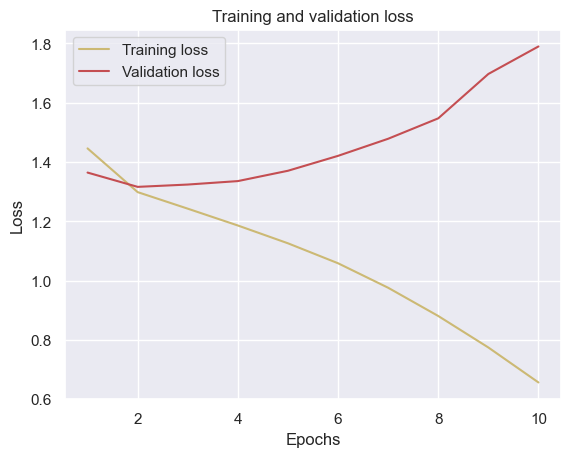

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

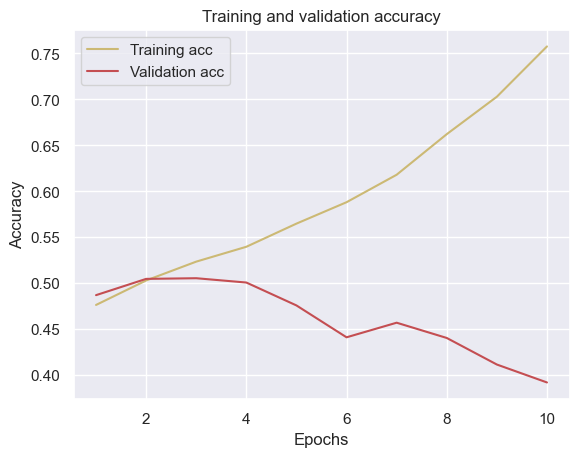

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [56]:
#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix


y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test_onehot,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

44/44 [==============================] - 0s 2ms/step


2024-06-21 14:43:00.431234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [57]:
#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.24      0.38      0.29       152
           1       0.06      0.08      0.07       100
           2       0.54      0.58      0.56       677
           3       0.24      0.15      0.18       194
           4       0.29      0.20      0.24       284

    accuracy                           0.39      1407
   macro avg       0.27      0.28      0.27      1407
weighted avg       0.38      0.39      0.38      1407

[[ 57   6  60   8  21]
 [ 22   8  44   9  17]
 [ 86  67 392  58  74]
 [ 16  13 107  29  29]
 [ 57  32 119  19  57]]


In [60]:
import keras
from keras import layers
from keras.models import Model
from keras.layers import Input, Conv1D, Flatten, Dense
from keras.layers import Input, Conv1D, Flatten, Dense, LSTM

input_layer = Input(shape=(n_timesteps, n_features))

conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
lstm = LSTM(30)(conv1)

dens = Dense(64, activation='relu')(lstm)
outputs = Dense(n_outputs, activation='softmax')(dens)

model = Model(inputs=input_layer, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 24)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 148, 64)           4672      
                                                                 
 lstm_1 (LSTM)               (None, 30)                11400     
                                                                 
 dense_6 (Dense)             (None, 64)                1984      
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 18,381
Trainable params: 18,381
Non-trainable params: 0
_________________________________________________________________


In [61]:
train_epochs = 10
history = model.fit(X_train, y_train_onehot, epochs=train_epochs, verbose=True,  validation_split = 0.2)

Epoch 1/10


2024-06-21 16:08:03.409996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-21 16:08:03.569926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-21 16:08:05.868548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - ETA: 0s - loss: 1.3125 - accuracy: 0.5035

2024-06-21 16:08:39.276518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-21 16:08:39.359990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - 42s 91ms/step - loss: 1.3125 - accuracy: 0.5035 - val_loss: 1.2490 - val_accuracy: 0.5347
Epoch 2/10
347/347 [==============================] - 22s 62ms/step - loss: 1.2456 - accuracy: 0.5333 - val_loss: 1.2245 - val_accuracy: 0.5394
Epoch 3/10
347/347 [==============================] - 21s 61ms/step - loss: 1.2316 - accuracy: 0.5369 - val_loss: 1.2211 - val_accuracy: 0.5379
Epoch 4/10
347/347 [==============================] - 20s 57ms/step - loss: 1.2259 - accuracy: 0.5378 - val_loss: 1.2238 - val_accuracy: 0.5386
Epoch 5/10
347/347 [==============================] - 20s 57ms/step - loss: 1.2251 - accuracy: 0.5378 - val_loss: 1.2175 - val_accuracy: 0.5383
Epoch 6/10
347/347 [==============================] - 19s 56ms/step - loss: 1.2195 - accuracy: 0.5421 - val_loss: 1.2089 - val_accuracy: 0.5477
Epoch 7/10
347/347 [==============================] - 20s 58ms/step - loss: 1.2164 - accuracy: 0.5405 - val_loss: 1.2169 - val_accuracy: 0.5430
Epo

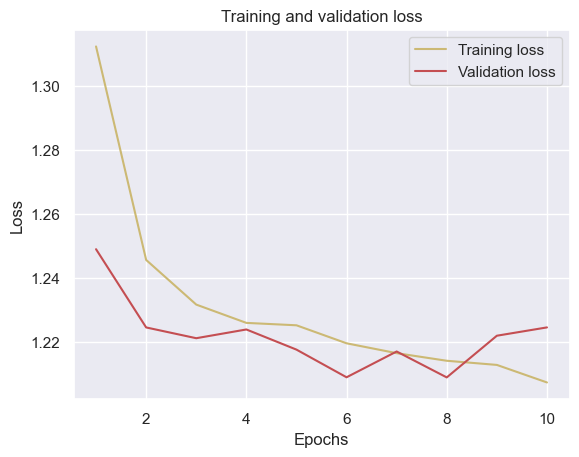

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

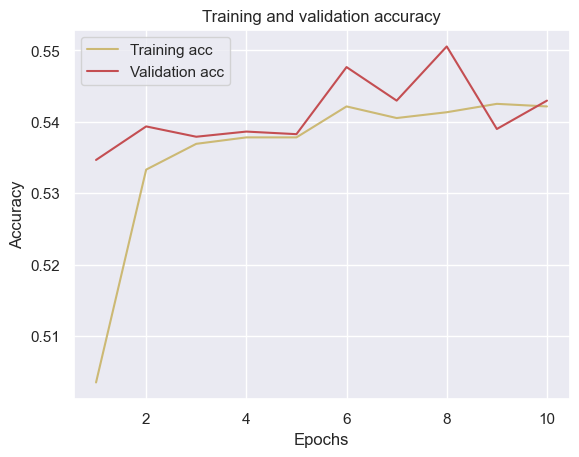

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()